# Importing libraries

In [1]:
pip install emoji

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sns
import re
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Data Cleaning
import emoji
from bs4 import BeautifulSoup
import re
import itertools



# Importing dataset


In [6]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test_with_no_labels.csv")

# Data Preprocessing

Reorder columns so that our predicted variable is the last column of the dataframe

In [7]:
column_titles = [col for col in train_df.columns if col!= 'sentiment'] + ['sentiment']
train_df = train_df.reindex(columns=column_titles)

In [8]:
##view your data
train_df.head()

,message,tweetid,sentiment
0,PolySciMajor EPA chief doesn't think carbon di...,625221,1
1,It's not like we lack evidence of anthropogeni...,126103,1
2,RT @RawStory: Researchers say we have three ye...,698562,2
3,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,1
4,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,1


In [9]:
#look at column names
train_df.columns

Index(['message', 'tweetid', 'sentiment'], dtype='object')

In [10]:
# Shape of the dataset
train_df.shape

(15819, 3)

In [11]:
# dataframe information
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   message    15819 non-null  object
 1   tweetid    15819 non-null  int64 
 2   sentiment  15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [12]:
# Checking for missing values
train_df.isnull().sum()

message      0
tweetid      0
sentiment    0
dtype: int64

There are no null values in our dataset

In [13]:
# Checking whether a character is white-space character or not
print(len(train_df['message']))
print(sum(train_df['message'].apply(lambda x: x.isspace())))

15819
0


In [14]:
# Looking at the how the messages are distributed across the sentiment
train_df.describe()

,tweetid,sentiment
count,15819.000000,15819.000000
mean,501719.433656,0.917504
std,289045.983132,0.836537
min,6.000000,-1.000000
25%,253207.500000,1.000000
50%,502291.000000,1.000000
75%,753769.000000,1.000000
max,999888.000000,2.000000


In [15]:
##see statistics for non-numerical columns
train_df.describe(include=['object'])

,message
count,15819
unique,14229
top,RT @StephenSchlegel: she's thinking about how ...
freq,307


In [16]:
# Looking at the numbers of possible classes in our sentiment
train_df['sentiment'].unique()

array([ 1,  2,  0, -1], dtype=int64)

In [17]:
##see statistics for categorical features
train_df['sentiment'].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [18]:
##See percentage for categorical features
train_df['sentiment'].value_counts(normalize = True) * 100

 1    53.922498
 2    23.010304
 0    14.874518
-1     8.192680
Name: sentiment, dtype: float64


While having taken a look at the data and what it entails we are able to see that it includes four sentiments which are our positive sentiment, negative sentiment, neutral sentiment as well as factual news sentiment.
We are able to observe that our positive sentiment is more popular compared to our negative sentiment followed by our factual news sentiment.

# Exploratory Data Analysis

EDA is primarily used to see what data can reveal beyond the formal modeling or hypothesis testing task and provides a better understanding of data set variables and the relationships between them.

C:\Users\matea\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


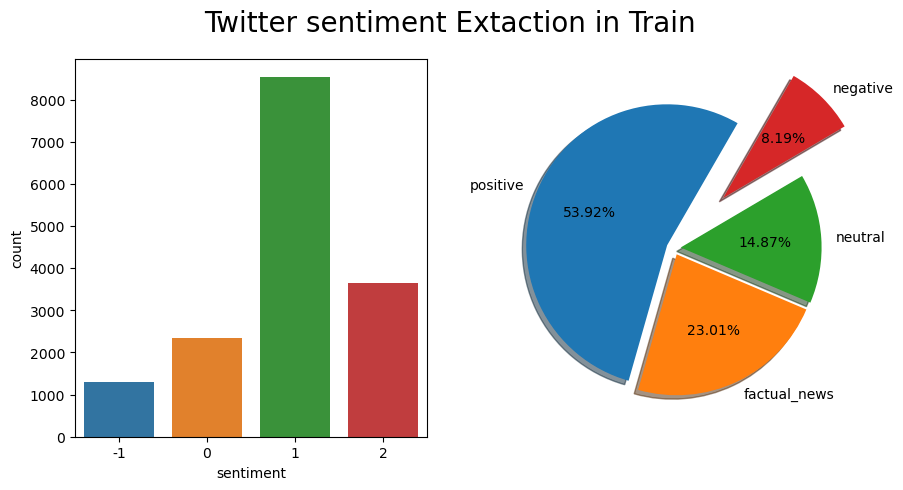

In [19]:

# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), dpi=100)
sns.countplot(train_df['sentiment'], ax=axes[0])
axes[1].pie(train_df['sentiment'].value_counts(),
            labels=['positive', 'factual_news', 'neutral','negative'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0.05, 0.05, 0.5),
            startangle=60)
fig.suptitle('Twitter sentiment Extaction in Train', fontsize=20)
plt.show()

From the distribution we are able to see that the positive sentiments are the most compared to the negative sentiments.The factual news is the 2nd popular and the least popular is the negative sentiment.

There is imbalanced data. Imbalance data occurs when the number of observations across different class labels are unevenly distributed.

C:\Users\matea\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\matea\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\matea\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

Text(0, 0.5, 'Density')

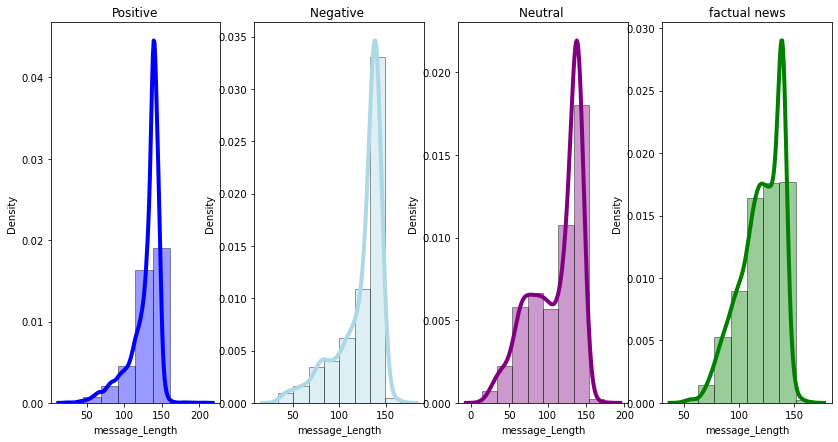

In [20]:
# Distribution plots for the label
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(14,7))

#For Positive 
sns.distplot(train_df[train_df['sentiment']==1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'blue', 
             ax = ax1,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax1.set_title('Positive')
ax1.set_xlabel('message_Length')
ax1.set_ylabel('Density')

#For Negative 
sns.distplot(train_df[train_df['sentiment']==-1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'lightblue', 
             ax = ax2,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax2.set_title('Negative ')
ax2.set_xlabel('message_Length')
ax2.set_ylabel('Density')

#For Neutral 
sns.distplot(train_df[train_df['sentiment']==0]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'purple',  
             ax = ax3,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax3.set_title('Neutral ')
ax3.set_xlabel('message_Length')
ax3.set_ylabel('Density')

#For factual news
sns.distplot(train_df[train_df['sentiment']==2]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'green', 
             ax = ax4,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax4.set_title('factual news')
ax4.set_xlabel('message_Length')
ax4.set_ylabel('Density')





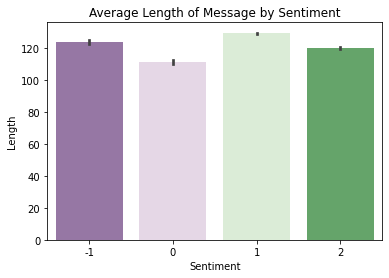

In [21]:
# Visualizing text lengths for each sentiment
sns.barplot(x='sentiment', y=train_df['message'].apply(len) ,data = train_df, palette='PRGn')
plt.ylabel('Length')
plt.xlabel('Sentiment')
plt.title('Average Length of Message by Sentiment')
plt.show()

Here we can visualise that both negative and postive tweets have roughly the highest average length of tweets, with Positive having a slightly higher average.

We will visualise whether a tagged user has any relation to the sentiment, and which users are most popular in each sentiment.

In [22]:
# Extracting Users in a column
train_df['users'] = [''.join(re.findall(r'@\w{,}', line)) 
                       if '@' in line else np.nan for line in train_df.message]

In [23]:
# Generating Counts of users
counts = train_df[['message', 'users']].groupby('users', as_index=False).count().sort_values(by='message', ascending=False)

In [24]:
# Top 5 most popular
counts.head()

,users,message
3410,@StephenSchlegel,307
3270,@SenSanders,243
6182,@realDonaldTrump,143
448,@BernieSanders,121
612,@CNN,106


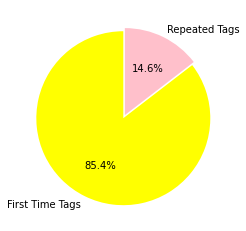

In [25]:
# checking the numerical distribution
values = [sum(np.array(counts['message']) == 1)/len(counts['message']), sum(np.array(counts['message']) != 1)/len(counts['message'])]
labels = ['First Time Tags', 'Repeated Tags']
colors = ['yellow', "pink"]
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode= (0.04, 0), colors=colors)
plt.show()

14.6% of the tweets are users tagged more than once. Depending on how influential the tagged users are, they may account for more a further portion of the data. Knowing who is tagged on a tweet may increase the chance of the model predict the correct sentiment of the tweet.

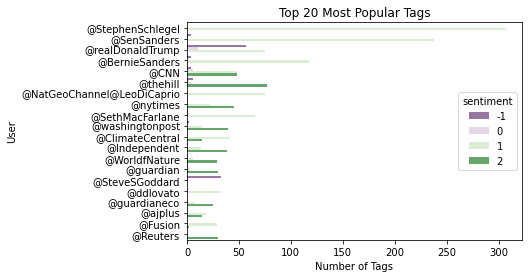

In [26]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(y="users", hue="sentiment", data=train_df, palette='PRGn',
              order=train_df.users.value_counts().iloc[:20].index) 

plt.ylabel('User')
plt.xlabel('Number of Tags')
plt.title('Top 20 Most Popular Tags')
plt.show()
#plt.xticks(rotation=90)

We are able to visualise that certain tags are commonly associated with a specific sentiment. There are some tags which are strongly associated with one sentiment. 

# Text Cleaning

The purpose of data cleaning is to remove noise, inconsistent data and errors in the training data,
in order to create a reliable dataset. This improves the quality of the training data for analytics and enables accurate decision-making.



In [27]:
from nltk.tokenize import TreebankWordTokenizer
#Try Tweet tokenizer
tokeniser = TreebankWordTokenizer()
train_df['tokens'] = train_df['message'].apply(tokeniser.tokenize)

# Defining the features as well as the label
X = train_df['tokens']

For the Tweeter dataset we will be doing the following steps:

removing url making everything lower case removing punctuation Using regular expressions we can effectively removes all websites and replaces them with the text 'web-url'


In [28]:
import string

In [29]:
def strip_accents(text):
    if 'ø' in text or  'Ø' in text:
        #Do nothing when finding ø 
        return text   
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)


def tweet_cleaning_for_sentiment_analysis(tweet):    
    #Escaping HTML characters
    tweet = BeautifulSoup(tweet).get_text()
    #Special case not handled previously.
    tweet = tweet.replace('\x92',"'")
    #Removal of hastags/account
    tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", tweet).split())
    #Removal of address
    tweet = ' '.join(re.sub("(\w+:\/\/\S+)", " ", tweet).split())
    #Removal of Punctuation
    tweet = ''.join([l for l in tweet if l not in string.punctuation])
    #Lower case
    tweet = tweet.lower()
    #CONTRACTIONS source: https://en.wikipedia.org/wiki/Contraction_%28grammar%29
    #CONTRACTIONS = load_dict_contractions()
    #tweet = tweet.replace("’","'")
    #words = tweet.split()
    #reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words]
    #tweet = " ".join(reformed)
    # Standardizing words
    #tweet = ''.join(''.join(s)[:2] for _, s in itertools.groupby(tweet))
    #Deal with smileys
    #source: https://en.wikipedia.org/wiki/List_of_emoticons
    #SMILEY = load_dict_smileys()  
    #words = tweet.split()
    #reformed = [SMILEY[word] if word in SMILEY else word for word in words]
    #tweet = " ".join(reformed)
    #Deal with emojis
    tweet = emoji.demojize(tweet)
    #Strip accents
    tweet= strip_accents(tweet)
    tweet = tweet.replace(":"," ")
    tweet = ' '.join(tweet.split())
    return tweet

In [40]:
train_df['message'] = train_df['message'].str.lower()

In [41]:
train_df['message']= train_df['message'].map(tweet_cleaning_for_sentiment_analysis)

In [42]:
train_df['message']

0        polyscimajor epa chief doesnt think carbon dio...
1        its not like we lack evidence of anthropogenic...
2        rt researchers say we have three years to act ...
3        wired 2016 was a pivotal year in the war on cl...
4        rt its 2016 and a racist sexist climate change...
                               ...                        
15814    rt they took down the material on global warmi...
15815    rt how climate change could be breaking up a 2...
15816    notiven rt nytimesworld what does trump actual...
15817    rt hey liberals the climate change crap is a h...
15818    rt cannon s climate change equation in 4 scree...
Name: message, Length: 15819, dtype: object

Find the most frequent words in the data, extracting information about its content and topics.



In [43]:
from nltk.corpus import stopwords

In [44]:
stops =  set(stopwords.words('english')+['com'])
co = CountVectorizer(stop_words=stops)
counts = co.fit_transform(train_df.message)
pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False).head(20)


,0
climate,12610
change,12562
rt,9720
global,3775
warming,3504
trump,1862
believe,1159
us,914
doesnt,887
real,718


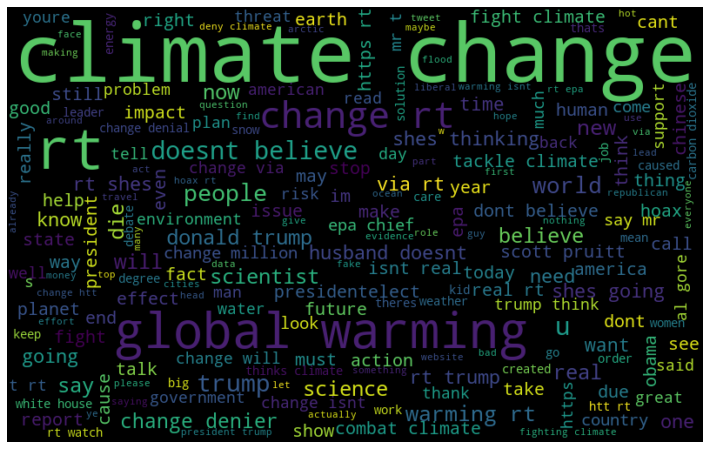

In [37]:
all_words = " ".join([sentence for sentence in train_df["message"]])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500,random_state=42, max_font_size=100).generate(all_words)

#plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

* **clean_tweet was not defined... clean text was assigned to df["message"]**

We can visualise that the most common words are climate change and global warming

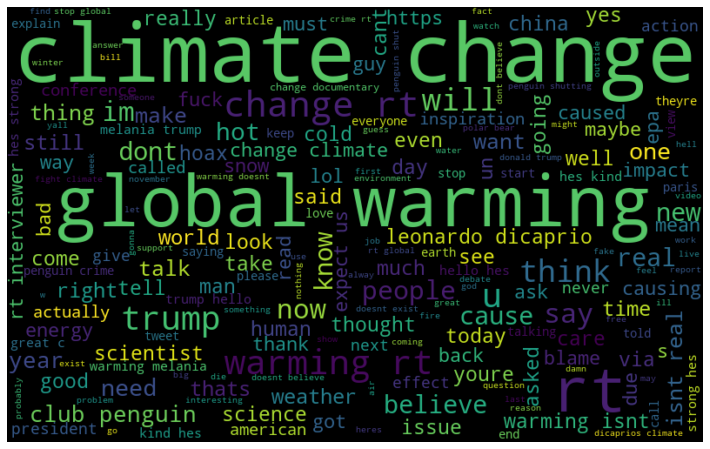

In [37]:
##frequent words neutral
all_words = " ".join([sentence for sentence in train_df["message"][train_df["sentiment"]==0]])

wordcloud = WordCloud(width=800, height=500,random_state=42, max_font_size=100).generate(all_words)

#plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

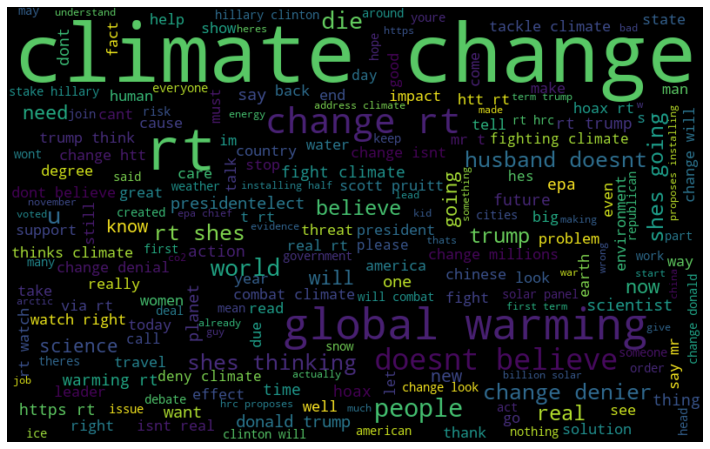

In [38]:
#frequent words positive
all_words = " ".join([sentence for sentence in train_df["message"][train_df["sentiment"]==1]])

wordcloud = WordCloud(width=800, height=500,random_state=42, max_font_size=100).generate(all_words)

#plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

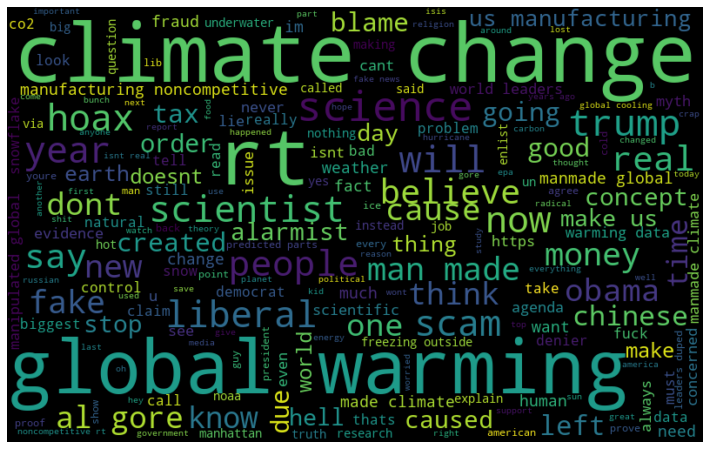

In [39]:
#frequent words negative
all_words = " ".join([sentence for sentence in train_df["message"][train_df["sentiment"]==-1]])

wordcloud = WordCloud(width=800, height=500,random_state=42, max_font_size=100).generate(all_words)

#plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

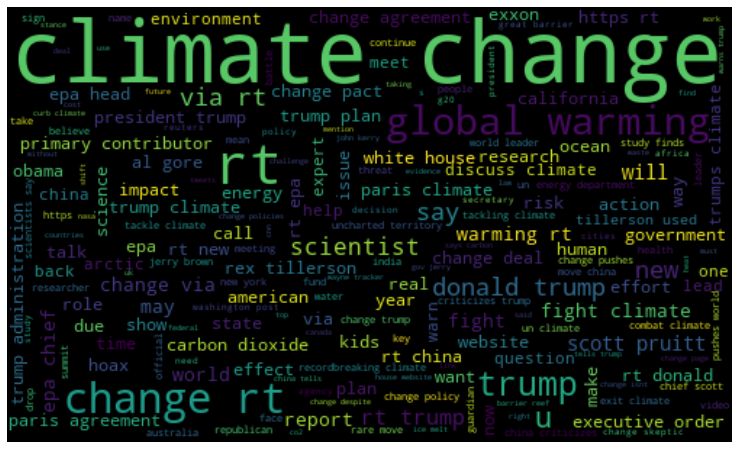

In [40]:
#frequent words factual news
all_words = " ".join([sentence for sentence in train_df["message"][train_df["sentiment"]==2]])

wordcloud = WordCloud(width=500, height=300,random_state=42, max_font_size=100).generate(all_words)

#plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()